<a href="https://colab.research.google.com/github/Mahenaz17595/Rossman/blob/master/Rossman_Using_Regression_and_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install plotly==2.7.0


     |████████████████████████████████| 25.0MB 168kB/s 
  Created wheel for plotly: filename=plotly-2.7.0-cp36-none-any.whl size=25015297 sha256=0b385f7556da9e5192a9d9a332885247f70e8d1c7c69d849b5f7d82c3cdf41cc
  Stored in directory: /root/.cache/pip/wheels/0c/3e/07/4848195c61f659184ca41d5a614845a018ab2d2f2a705b9998
Successfully built plotly
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1, but you'll have plotly 2.7.0 which is incompatible.
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import plotly 
import plotly.graph_objs as go
import plotly.plotly as py
#import chart_studio.plotly as py
#from chart_studio.plotly import iplot
import sklearn
import warnings
warnings.filterwarnings("ignore")


# statistics

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from pandas import DataFrame

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**2. Data Preparation**


**2.1 Load Dataset**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
url_store = '/content/drive/My Drive/Project_3/Dataset/store.csv'
store = pd.read_csv(url_store)

url_train = '/content/drive/My Drive/Project_3/Dataset/train.csv'
train = pd.read_csv(url_train,parse_dates = True, index_col = 'Date')

In [0]:
print("# of observations & # of features", train.shape)
train.head()

# of observations & # of features (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [0]:
print("# of observations & # of features", store.shape)
store.head()

# of observations & # of features (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


**2.2 Dealing With Missing Values**

**2.2.1 Count missing values in each dataset**

In [0]:
print("train:\n\n", train.isnull().sum(),  
     "\n\nstore:\n\n", store.isnull().sum())

train:

 Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 

store:

 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


**2.2.2 Remove features with high percentages of missing values**

we can see that some features have a high percentage of missing values and they won't be accurate as indicators, so we will remove features with more than 30% missing values.

In [0]:
# remove features
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)


**2.2.3 Replace missing values in features with low percentages of missing values**


Text(0.5, 1.0, 'Distributin of Store Competition Distance')

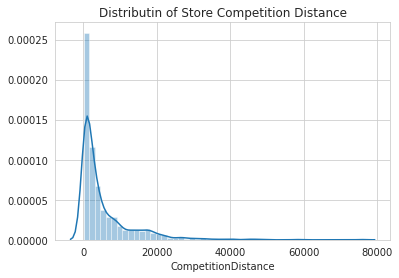

In [0]:
# CompetitionDistance is distance in meters to the nearest competitor store
# let's first have a look at its distribution
sns.distplot(store.CompetitionDistance.dropna())
plt.title("Distributin of Store Competition Distance")

**The distribution is right skewed, so we'll replace missing values with the median.**

In [0]:
# replace missing values in CompetitionDistance with median for the store dataset
store.CompetitionDistance.fillna(store.CompetitionDistance.median(), inplace=True)

**2.3 Date Extraction**

In [0]:
# extract year, month, day and week of year from "Date"
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train = train.reset_index()

**`2.4 Joining Tables`**

In [0]:
df = pd.merge(train, store, how='left', on='Store')
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,0
1,2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,1
2,2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,1
3,2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,0
4,2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,0


In [0]:
len(df)

1017209


**2.5 Drop Subsets Of Data Where Might Cause Bias**

In [0]:
# where stores are closed, they won't generate sales, so we will remove this part of the dataset
df = df[df.Open != 0]

In [0]:
# Open isn't a variable anymore, so we'll drop it
df = df.drop('Open', axis=1)

In [0]:
# see if there's any opened store with zero sales
df[df.Sales == 0]['Store'].sum()

31460

In [0]:
# see the percentage of open stored with zero sales
df[df.Sales == 0]['Sales'].sum()/df.Sales.sum()

0.0

In [0]:
# remove this part of data to avoid bias
df = df[df.Sales != 0]

**2.6 Feature Engineering**

In [0]:
# see what variable types we have
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 844338 non-null  datetime64[ns]
 1   Store                844338 non-null  int64         
 2   DayOfWeek            844338 non-null  int64         
 3   Sales                844338 non-null  int64         
 4   Customers            844338 non-null  int64         
 5   Promo                844338 non-null  int64         
 6   StateHoliday         844338 non-null  object        
 7   SchoolHoliday        844338 non-null  int64         
 8   Year                 844338 non-null  int64         
 9   Month                844338 non-null  int64         
 10  Day                  844338 non-null  int64         
 11  WeekOfYear           844338 non-null  int64         
 12  StoreType            844338 non-null  object        
 13  Assortment   

In [0]:
# see what's in nominal varibles 
set(df.StateHoliday), set(df.StoreType), set(df.Assortment)

({'0', 0, 'a', 'b', 'c'}, {'a', 'b', 'c', 'd'}, {'a', 'b', 'c'})

In [0]:
# StateHoliday indicates a state holiday - a = public holiday, b = Easter holiday, c = Christmas, 0 = None
# convert number 0 to string 0
df.loc[df.StateHoliday == 0,'StateHoliday'] = df.loc[df.StateHoliday == 0,'StateHoliday'].astype(str)

In [0]:
# make a copy in case I mess up anything 
df1 = df.copy()

**2.6.1 Create new variable "AvgSales"**

create a variable that calculates monthly average sales for each store

In [0]:
# calculate weekly average sales
sales = df1[['Year','Month','Store','Sales']].groupby(['Year','Month','Store']).mean()
sales = sales.rename(columns={'Sales':'AvgSales'})
sales = sales.reset_index()

In [0]:
df1['sales_key']=df1['Year'].map(str) + df1['Month'].map(str) + df1['Store'].map(str)
sales['sales_key']=sales['Year'].map(str) + sales['Month'].map(str) + sales['Store'].map(str)

In [0]:
# drop extra columns
sales = sales.drop(['Year','Month','Store'], axis=1)
# merge
df1 = pd.merge(df1, sales, how='left', on=('sales_key'))

**2.6.2 Create new variable "AvgCustomer"**

create a variable that calculates Monthly average number of customers for each store, becuase daily number of customer is another variable to be predicted

In [0]:
# calculate weekly average
cust = df1[['Year','Month','Store','Customers']].groupby(['Year','Month', 'Store']).mean()
cust = cust.rename(columns={'Customers':'AvgCustomer'})
cust = cust.reset_index()

In [0]:
df1['cust_key']=df1['Year'].map(str) + df1['Month'].map(str) + df1['Store'].map(str)
cust['cust_key']=cust['Year'].map(str) + cust['Month'].map(str) + cust['Store'].map(str)

In [0]:
# drop original feature Customers
df1 = df1.drop('Customers', axis=1)# drop extra columns
cust = cust.drop(['Year', 'Month', 'Store'], axis=1)

In [0]:
# merge
df1 = pd.merge(df1, cust, how="left", on=('cust_key'))

**2.6.3 Transform Variable "StateHoliday"**

In [0]:
# 0 - not a state holiday; 1- is on a state holiday
df1['StateHoliday'] = df1.StateHoliday.map({'0':0, 'a':1 ,'b' : 1,'c': 1})

In [0]:
# drop extra columns
df1 = df1.drop(['cust_key','sales_key','Store','Date'], axis=1)

**3. Exploratory Data Analysis**

In [0]:
# becasue my computer keeps crashing, I had to sample the dataset 
dfv = df.sample(n=5000, random_state=1)

In [0]:
# set up credential file for plotly
plotly.tools.set_credentials_file(username='Rahela', api_key='z68GRrmS2DGFmn5ni6IO')


In [0]:
corr = df1.corr()

Text(0.5, 1.0, 'Correlation Heatmap')

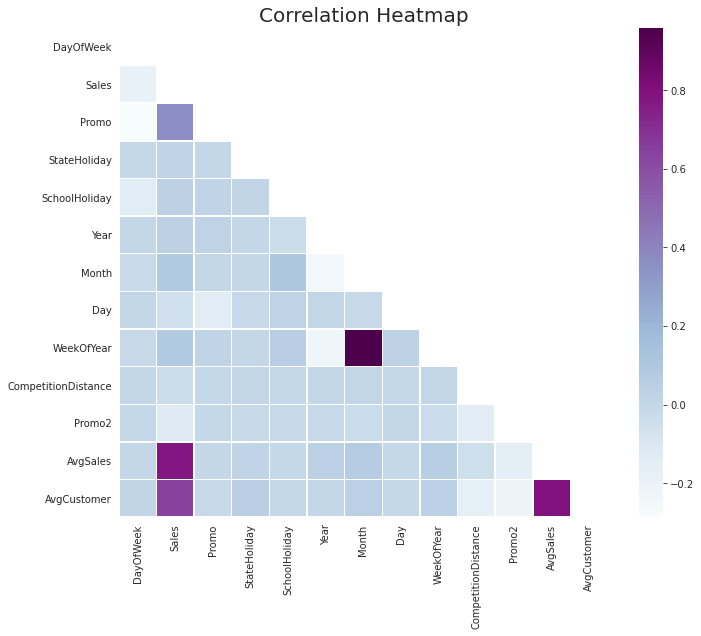

In [0]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(corr, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")
plt.title("Correlation Heatmap", fontsize=20)

In [0]:
promo0 = dfv.query('Promo==0')
promo0 = promo0.rename(columns={'Sales':'No_Promotion_Sales'})
promo1 = dfv.query('Promo==1')
promo1 = promo1.rename(columns={'Sales':'Promotion_Sales'})
x1 = promo0.No_Promotion_Sales
x2 = promo1.Promotion_Sales

Text(0, 0.5, 'Sales')

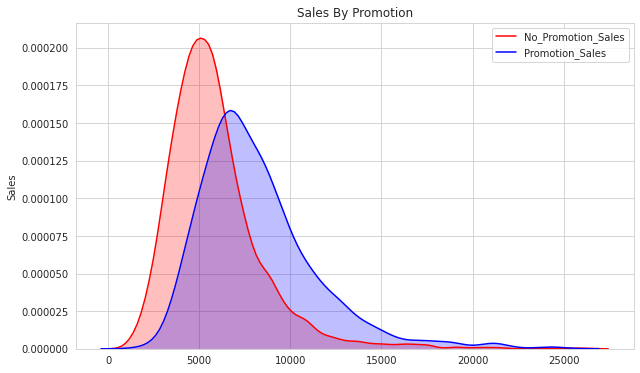

In [0]:
plt.figure(figsize=(10,6))
ax = sns.kdeplot(x1, shade=True, color="r")
ax = sns.kdeplot(x2, shade=True, color="b")
plt.title("Sales By Promotion")
plt.ylabel('Sales')

In [0]:
dfd = df1.sample(n=50000, random_state=1)


In [0]:
# split features and labels
X = dfd.drop('Sales', axis=1)
y = dfd. Sales


In [0]:
# get dummy variables for categorical features for linear regression
xd = X.copy()
xd = pd.get_dummies(xd)

In [0]:
# label nominal variables for tree based regression
xl = X.copy()

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
xl.StateHoliday = label.fit_transform(xl.StateHoliday)
xl.Assortment = label.fit_transform(xl.Assortment)
xl.StoreType = label.fit_transform(xl.StoreType)

In [0]:
# split training and test datasets
from sklearn.model_selection import train_test_split

#from sklearn.cross_validation import train_test_split
xd_train,xd_test,yd_train,yd_test = train_test_split(xd,y,test_size=0.3, random_state=1)
xl_train,xl_test,yl_train,yl_test = train_test_split(xl,y,test_size=0.3, random_state=1)


**4.1 Linear Regression**

In [0]:
from sklearn.linear_model import LinearRegression
lin= LinearRegression()
linreg = lin.fit(xd_train, yd_train)

In [0]:
# definte RMSE function
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

# definte MAPE function
def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100  

def rmspe(x, y):
  #return np.sqrt(np.mean((x/y) ** 2))*100 
  #return np.sqrt(np.mean((x-y)/x) ** 2)*100 
  return np.sqrt(np.mean(np.square(((x - y) / x))))

  

  
# get cross validation scores 
yd_predicted = linreg.predict(xd_train)
yd_test_predicted = linreg.predict(xd_test)

print("Training Accuracy" , ":" , linreg.score(xd_train, yd_train) , "," ,
      "Testing Accuarcy" ,":" , linreg.score(xd_test, yd_test))
print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training RMSPE", ":", rmspe(yd_train, yd_predicted),
      "Testing RMSPE", ":", rmspe(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yd_train, yd_predicted),
      "Testing MAPE", ":", mape(yd_test, yd_test_predicted))

Training Accuracy : 0.7534426463092014 , Testing Accuarcy : 0.7374031695181285
Training RMSE : 1558.666986443433 Testing RMSE : 1569.7998978110754
Training RMSPE : 0.2619986380394994 Testing RMSPE : 0.26469782961321525
Training MAPE : 16.994613661283044 Testing MAPE : 17.223983944754266


**4.2 Random Forest Regression**



In [0]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor(n_estimators=30)
rdfreg = rdf.fit(xl_train, yl_train)

In [0]:
print("Training Accuracy" , ":" , rdfreg.score(xl_train, yl_train) , "," ,
      "Testing Accuracy" ,":" , rdfreg.score(xl_test, yl_test))   

yl_predicted = rdfreg.predict(xl_train)
yl_test_predicted = rdfreg.predict(xl_test)

print("Training RMSE", ":", rmse(yl_train, yl_predicted),
      "Testing RMSE", ":", rmse(yl_test, yl_test_predicted))
print("Training RMSPE", ":", rmspe(yd_train, yd_predicted),
      "Testing RMSPE", ":", rmspe(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yl_train, yl_predicted),
      "Testing MAPE", ":", mape(yl_test, yl_test_predicted))

Training Accuracy : 0.9780123854935561 , Testing Accuracy : 0.8413939187398877
Training RMSE : 465.46112399197534 Testing RMSE : 1219.998998102321
Training RMSPE : 0.2619986380394994 Testing RMSPE : 0.26469782961321525
Training MAPE : 4.758080076846921 Testing MAPE : 12.61069373334949


**4.3 K-Nearest Neighbors Regression**



In [0]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 30)
knnreg = knn.fit(xd_train, yd_train)

In [0]:
print("Training Accuracy" , ":" , knnreg.score(xd_train, yd_train) , "," ,
      "Testing Accuracy" ,":" , knnreg.score(xd_test, yd_test))

yd_predicted = knnreg.predict(xd_train)
yd_test_predicted = knnreg.predict(xd_test)

print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training RMSPE", ":", rmspe(yd_train, yd_predicted),
      "Testing RMSPE", ":", rmspe(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yd_train, yd_predicted),
      "Testing MAPE", ":", mape(yd_test, yd_test_predicted))

Training Accuracy : 0.6275761316749886 , Testing Accuracy : 0.57616778527949
Training RMSE : 1915.6365301074293 Testing RMSE : 1994.3277777509113
Training RMSPE : 0.3469865014095355 Testing RMSPE : 0.36612267420879363
Training MAPE : 22.923501535229647 Testing MAPE : 23.86797893442435


In [0]:
for x in range(1,15):
    knn = KNeighborsRegressor(n_neighbors = x)
    knnreg = knn.fit(xd_train, yd_train)
    print("Regresion Model Score" , ":" , knnreg.score(xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , knnreg.score(xd_test, yd_test))

Regresion Model Score : 1.0 , Out of Sample Test Score : 0.2568662059879595
Regresion Model Score : 0.8260507138458782 , Out of Sample Test Score : 0.42427432580945346
Regresion Model Score : 0.7624912347255007 , Out of Sample Test Score : 0.4862514313830809
Regresion Model Score : 0.7295685142655963 , Out of Sample Test Score : 0.5118785656033964
Regresion Model Score : 0.7083883488235312 , Out of Sample Test Score : 0.5316238924579666
Regresion Model Score : 0.6921137957106409 , Out of Sample Test Score : 0.5420025256528676
Regresion Model Score : 0.6819028242731748 , Out of Sample Test Score : 0.5474864389769398
Regresion Model Score : 0.6737819470988362 , Out of Sample Test Score : 0.5529378320048752
Regresion Model Score : 0.6679587864018279 , Out of Sample Test Score : 0.5579367597393575
Regresion Model Score : 0.6616134612124918 , Out of Sample Test Score : 0.5618922745198187
Regresion Model Score : 0.6561654273732106 , Out of Sample Test Score : 0.5635035948021927
Regresion Mod

Among Linear Regression(OLS), Random Forest and KNN. Random Forest Model Performed better.



Feature Importance



Text(0.5, 0, 'Relative Importance')

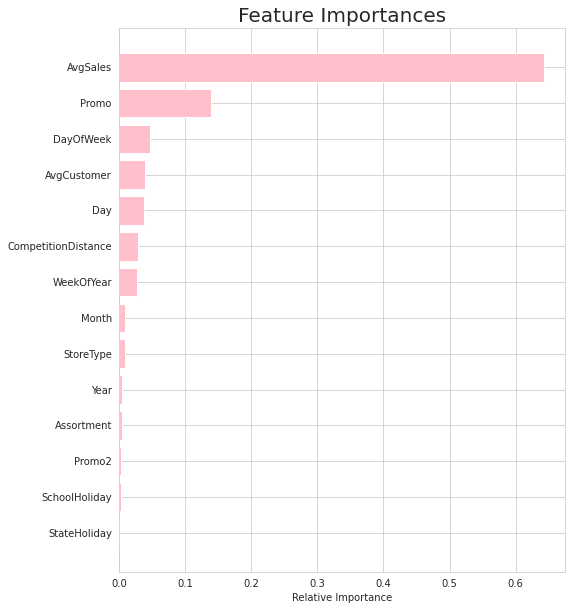

In [0]:
features = xl_train.columns
importances = rdfreg.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,10))
plt.title('Feature Importances', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='pink', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')


# **Time Series Analysis**



**Time-Series Analysis per Store Type**

In Time Series, the data changes with the time. With an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.

In [0]:
train1 = train


In [0]:
train1.head()


,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
1,2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2,2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
3,2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
4,2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


In [0]:
train2 = pd.merge(train1, store, on='Store')    ## for TimeSeries Arima Model
train2.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2'],
      dtype='object')

In [0]:
train2 = train2.set_index('Date')


In [0]:
train2.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2
Date,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,0
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,30,31,c,a,1270.0,0
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,29,31,c,a,1270.0,0
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,28,31,c,a,1270.0,0
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,27,31,c,a,1270.0,0


In [0]:
train2['Sales'] = train2['Sales'] * 1.0


In [0]:
sales_a = train2[train2.Store == 2]['Sales']
sales_b = train2[train2.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train2[train2.Store == 1]['Sales']
sales_d = train2[train2.Store == 13]['Sales']

Lets plot the sales of each store on Weekly basis



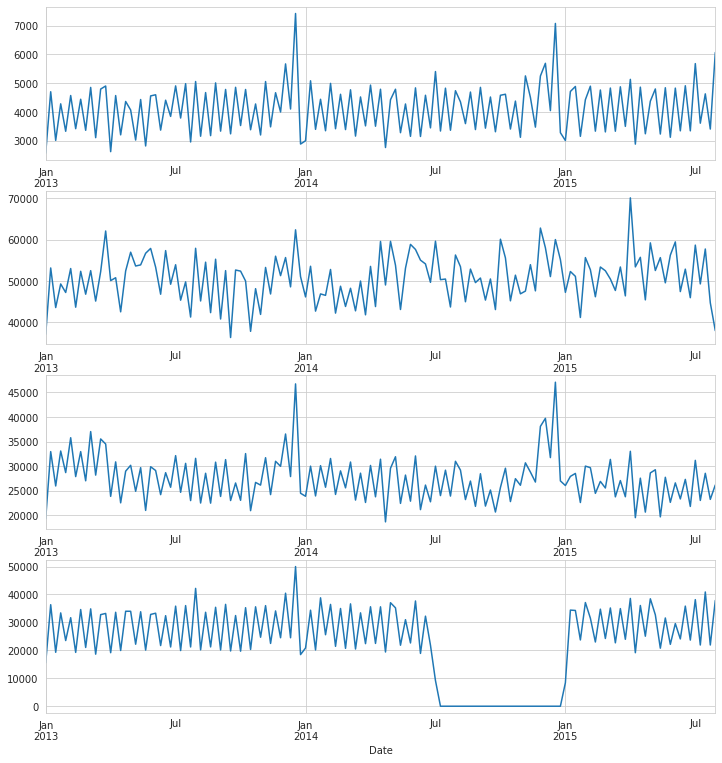

In [0]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').mean().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)

In [0]:
def auto_corr(sales):
  
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')


    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

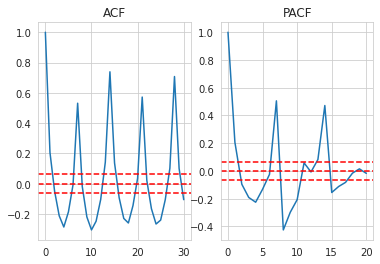

In [0]:
auto_corr(sales_a)


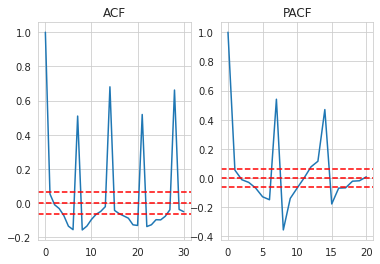

In [0]:
auto_corr(sales_b)


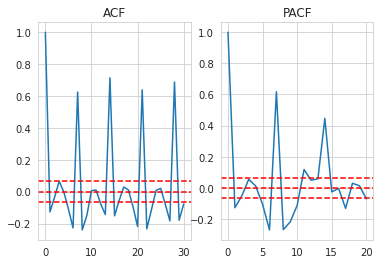

In [0]:
auto_corr(sales_c)


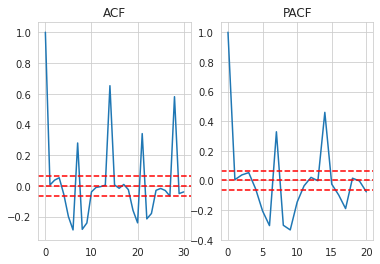

In [0]:
auto_corr(sales_d)


In [0]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
def sample(sales):
  return(sales.resample('MS').mean())

In [0]:
y_sale_a = sample(sales_a)
y_sale_b = sample(sales_b)
y_sale_c = sample(sales_c)
y_sale_d = sample(sales_d)

In [0]:
def model(i,sale):
  ex = train2.loc[train2['Store'] == i,['Customers','Promo']]
#   ex = train2.loc[train2['Store'] == i]
#   ex.drop(['Open','PromoInterval','monthStr','Customers'],axis=1,inplace =True)
  y_sales = sale.resample('MS').mean()
  y_ex = ex.resample('MS').mean()
  exog = sm.add_constant(y_ex)
  exog.tail()
  return y_sales , exog

In [0]:
y_sale_model_a , exog_a = model(2,sales_a)
y_sale_model_b , exog_b = model(85,sales_b)
y_sale_model_c , exog_c = model(1,sales_c)
y_sale_model_d , exog_d = model(13,sales_d)

In [0]:
exog_a = exog_a.dropna()
exog_a.isna().sum()

exog_b = exog_b.dropna()
exog_b.isna().sum()

exog_c = exog_c.dropna()
exog_c.isna().sum()

exog_d = exog_d.dropna()
exog_d.isna().sum()

const        0
Customers    0
Promo        0
dtype: int64

In [0]:
def arima(y_sale,exog,or1,sord):
    mod = sm.tsa.statespace.SARIMAX(y_sale,
                                    exog,
                                    order=or1,
                                    seasonal_order=sord,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)



    results = mod.fit(disp=0)
    ## predictions
    pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'), dynamic=False)
    pred_ci = pred.conf_int()

   ##plot
    ax = y_sale['2013':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

    ax.fill_between(pred_ci.index,
                      pred_ci.iloc[:, 1],
                      pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('sales')
    plt.legend()

    plt.show()


    y_forecasted = pred.predicted_mean
    y_truth = y_sale['2015-01-01':'2015-07-01']

   ##  Computing the mean square error
    mse = ((y_forecasted - y_truth) ** 2).mean()
    rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
    rmspe =  np.sqrt(np.mean((y_forecasted/y_truth) ** 2))
    return results , mse,rmse,rmspe

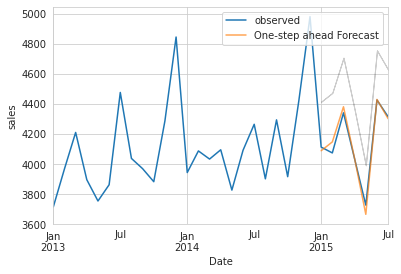

The Mean Squared Error of our forecasts is 1644.42
The Root Squared Error of our forecasts is 40.55
The Root Mean Squared Percentage Error of our forecasts is 1.0


In [0]:
or_a = (5,1,3)
sord_a=(1, 0, 0, 12)
result_a,mse_a,rmse_a,rmspe_a= arima(y_sale_model_a,exog_a,or_a,sord_a)
#print(result_a.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_a, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_a, 2)))
print('The Root Mean Squared Percentage Error of our forecasts is {}'.format(round(rmspe_a, 2)))

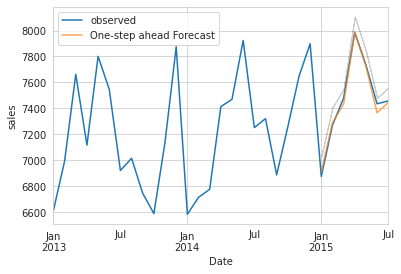

The Mean Squared Error of our forecasts is 1275.68
The Root Squared Error of our forecasts is 35.72
The Root Mean Squared Percentage Error of our forecasts is 1.0


In [0]:
or_b = (3,2,3)
sord_b=(1, 0, 0, 12)
result_b,mse_b,rmse_b,rmspe_b= arima(y_sale_model_b,exog_b,or_b,sord_b)
#print(result_b.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_b, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_b, 2)))
print('The Root Mean Squared Percentage Error of our forecasts is {}'.format(round(rmspe_b, 2)))

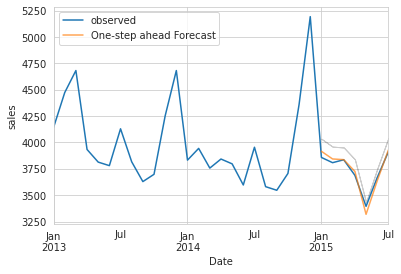

The Mean Squared Error of our forecasts is 1854.65
The Root Squared Error of our forecasts is 43.07
The Root Mean Squared Percentage Error of our forecasts is 1.0


In [0]:
or_c = (2,1,2)
or_c = (2,1,2)
sord_c=(1, 0, 0, 12)
result_c,mse_c,rmse_c,rmspe_c= arima(y_sale_model_c,exog_c,or_c,sord_c)
#print(result_c.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_c, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_c, 2)))
print('The Root Mean Squared Percentage Error of our forecasts is {}'.format(round(rmspe_c, 2)))